# BayesTME Demo

In this notebook we will demonstrate running the bayestme pipeline end to end on a sample dataset.

We will use a very small simulated dataset for this demo such that this notebook can be fully executed quickly and with a small amount of resources.

In [57]:
import numpy as np
from bayestme import bleeding_correction, data

np.random.seed(101)

locations, tissue_mask, true_rates, true_counts, bleed_counts = bleeding_correction.generate_data(
    n_rows=25,
    n_cols=25,
    n_genes=10)

stdata = data.SpatialExpressionDataset(
    raw_counts=bleed_counts,
    tissue_mask=tissue_mask,
    positions=locations.T,
    gene_names=np.array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10']),
    layout=data.Layout.SQUARE
)

0
100
200
300
400
500
600


Below is a visualization of the raw count data for one gene to give a sense of what this simulated dataset looks like.

Plot saved as ./1_raw_counts.png


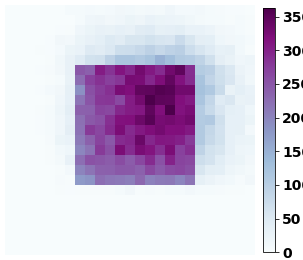

In [58]:
import numpy as np
from bayestme import plotting
from IPython.display import Image

plotting.plot_gene_raw_counts(
    stdata,
    gene='1',
    output_format='png',
    output_dir='.')

Image(filename='1_raw_counts.png', unconfined=True) 

Once we have loaded our spatial transcriptomics dataset, to keep posterior inference computationally tractable, we select the top G genes ordered by spatial variation in log space. Specifically, we transform the reads as log(1+R) and rank each column by the variance, keeping the top G. The logarithmic transform separates spatial variation from natural variation that arises due to simply having a higher overall expression rate. We then drop all ribosomal genes (i.e., those matching an ‘rp’ regular expression). After selecting and filtering the top genes, we work directly with the UMI read counts.

In this case we don't have any ribosomal genes, but we can choose the top 5 genes by spatial variation like so:

In [59]:
len(stdata.gene_names)

10

In [60]:
from bayestme import gene_filtering

stdata_stddev_filtered = gene_filtering.select_top_genes_by_standard_deviation(
    stdata, n_gene=5)

In [61]:
len(stdata_stddev_filtered.gene_names)

5

Now that we have filtered the gene markers down, we perform bleeding correction

BayesTME uses the four cardinal directions (North, South, East, and West) for the basis functions. This choice is based on the observation that UMIs tend to bleed toward one corner. We also observed that bleeding appears to be less extreme in tissue regions than non-tissue regions. Thus, BayesTME distinguishes between in- and out-of-tissue distance by learning four separate basis functions for each region. The distance from an original spot i′ to its observed spot i is then a summation of the in- and out-of-tissue components of a straight line between the two spots.

The `n_top` parameter controls how many of the filtered gene markers we want to consider for this analysis. We will just use a few for the purposes of this demonstration to make the computation faster.

In [62]:
from bayestme import bleeding_correction

cleaned_dataset, bleed_correction_result = bleeding_correction.clean_bleed(
    dataset=stdata_stddev_filtered,
    n_top=3,
    local_weight=None,
    max_steps=3
)

Fitting basis functions to first 3 genes

Step 1/3
	Loss: 2193.43

Step 2/3
	Loss: 1643.95

Step 3/3
	Loss: 1628.99

Gene 1/5

Gene 2/5

Gene 3/5

Gene 4/5

Gene 5/5


We will next create some plots for what bleeding correction did, the first plot shows the raw counts for a single marker vs the corrected counts.

Plot saved as ./9_bleeding_plot.png
Plot saved as ./10_bleeding_plot.png
Plot saved as ./3_bleeding_plot.png
Plot saved as ./7_bleeding_plot.png
Plot saved as ./2_bleeding_plot.png


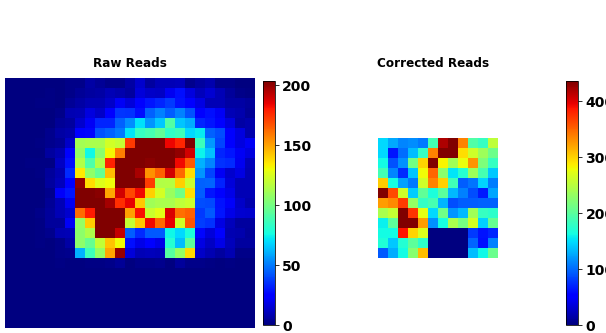

In [63]:
bleeding_correction.create_top_n_gene_bleeding_plots(
        dataset=stdata_stddev_filtered,
        corrected_dataset=cleaned_dataset,
        bleed_result=bleed_correction_result,
        output_dir='.',
        output_format='png',
        n_genes=5)

Image(filename='{}_bleeding_plot.png'.format(cleaned_dataset.gene_names[0]), unconfined=True) 


The second plot shows the "bleed vectors", for each spot the bleed vector indicates where reads for the marker in that spot likely came from. We see the vectors for outside-tissue spots point towards the in-tissue spots in the middle, indicating their reads came from there.

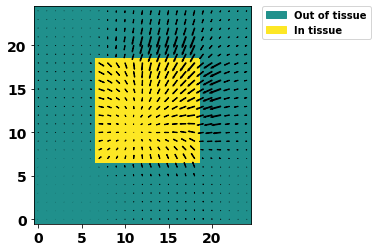

In [64]:
Image(filename='bleed_vectors_{}.png'.format(cleaned_dataset.gene_names[0]), unconfined=True) 

After the data has been bleed corrected, BayesTME automatically chooses the number of cell types K via M-fold cross-validation. For each fold, a random non-overlapping subset of the spots are held out; we use M = 5 folds with 5% of spots held out in each fold. The spatial priors in BayesTME enable imputation of the cell type probabilities at each held out spot in the training data. For each fold, we fit over a discrete grid of λ smoothness values. For a given fold m, cell type count K, and smoothness level λ, we calculate the approximate marginal log-likelihood of the held out spots. Results are averaged over all λ values for each fold and then averaged across each fold. The λ averaging is an empirical Bayes estimate with a discrete prior on λ integrated out; the cross-validation averaging is an unbiased approach to selecting K. After selecting K, we refit BayesTME on the entire data using the chosen K and the λ with average cross-validation log-likelihood closest to the overall average.

In [65]:
import os
from bayestme import phenotype_selection
from pathlib import Path

Path("./k_fold_results").mkdir(exist_ok=True)


parameter_generator = phenotype_selection.get_phenotype_selection_parameters_for_folds(
    stdata=cleaned_dataset,
    n_fold=2,
    n_splits=2,
    lams=[10, 100, 1000],
    n_components_min=2,
    n_components_max=5
)


for job_index, (lam, n_components_for_job, mask, fold_number) in enumerate(parameter_generator):
    result: data.PhenotypeSelectionResult = phenotype_selection.run_phenotype_selection_single_job(
            lam=lam,
            n_components=n_components_for_job,
            mask=mask,
            fold_number=fold_number,
            stdata=stdata,
            n_samples=2,
            n_burn=2,
            n_thin=1,
            max_ncell=100,
            n_gene=3,
            background_noise=False,
            lda_initialization=False
    )

    result.save(os.path.join('./k_fold_results', 'fold_{}.h5ad'.format(job_index)))

The maxiumum value of K, and the value of λ with average cross-validation log-likelihood closest to the overall average will be used for the subsequent deconvolution and spatial differential expression steps:

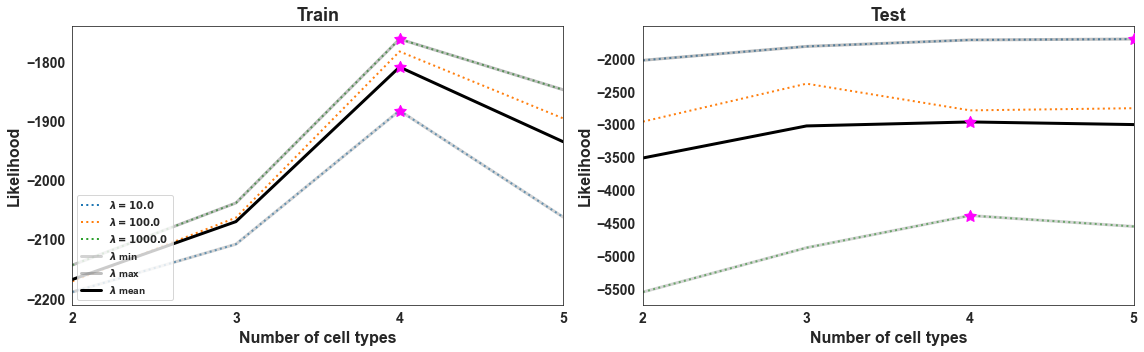

In [66]:
from bayestme import cv_likelihoods


likelihoods, fold_nums, lam_vals, k_vals = cv_likelihoods.load_likelihoods('./k_fold_results')

best_n_components = cv_likelihoods.get_max_likelihood_n_components(likelihoods, k_vals)

best_lambda = cv_likelihoods.get_best_lambda_value(
    likelihoods,
    np.argmax(k_vals == best_n_components),
    lam_vals)

cv_likelihoods.plot_cv_running('./k_fold_results', out_path='.', output_format='png')


Image(filename='cv_running.png', unconfined=True) 


In [67]:
(best_n_components, best_lambda)

(4, 100)

Next we run the deconvolution step, using the values of lambda and n_components learned in the previous step:

In [68]:
from bayestme import deconvolution

deconvolution_result = deconvolution.deconvolve(
        reads=cleaned_dataset.reads,
        edges=cleaned_dataset.edges,
        n_gene=5,
        n_components=3,
        lam2=100,
        n_samples=10,
        n_burnin=10,
        n_thin=1,
        random_seed=999,
        bkg=False,
        lda=False)

In [69]:
Path("./deconvolution_plots").mkdir(exist_ok=True)

deconvolution.plot_deconvolution(
        stdata=cleaned_dataset,
        deconvolution_result=deconvolution_result,
        output_dir='./deconvolution_plots',
        output_format='png',
        n_marker_genes=1,
        alpha=0.05,
        marker_gene_method=deconvolution.MarkerGeneMethod.TIGHT)


Plot saved as ./deconvolution_plots/cell_number.png
Plot saved as ./deconvolution_plots/cell_probability.png


These plots show the number and probability for each cell type over each spot.

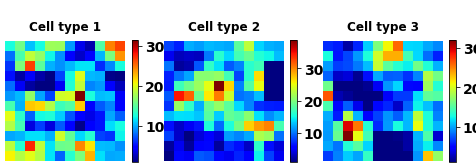

In [70]:
Image(filename='./deconvolution_plots/cell_number.png', unconfined=True) 

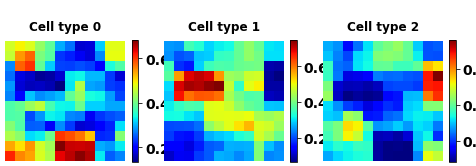

In [71]:
Image(filename='./deconvolution_plots/cell_probability.png', unconfined=True) 

This plot shows the marker genes that are associated with each learned cell type.

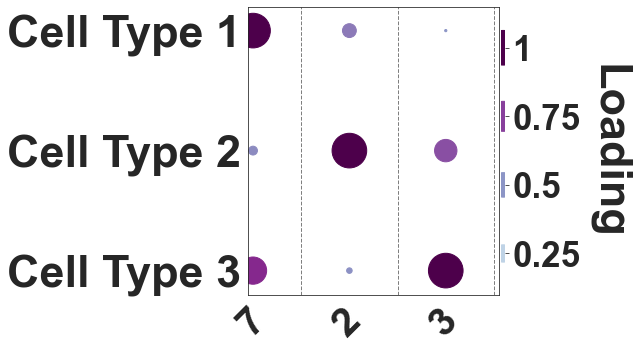

In [76]:
Image(filename='./deconvolution_plots/marker_genes.png', unconfined=True) 

Next we will run the spatial differential expression routine, using the lambda parameter selected from cross validation 

In [72]:
from bayestme import spatial_expression

spatial_differential_expression_results = spatial_expression.run_spatial_expression(
    dataset=cleaned_dataset,
    deconvolve_results=deconvolution_result,
    n_spatial_patterns=5,
    n_samples=10,
    n_burn=10,
    n_thin=1,
    n_cell_min=2,
    alpha0=10,
    prior_var=100.0,
    lam2=100,
    simple=True)

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19


Next we plot spatial programs that meet certain criteria:

In [73]:
Path("./sde_plots").mkdir(exist_ok=True)

spatial_expression.plot_spatial_patterns(
    stdata=stdata,
    decon_result=deconvolution_result,
    sde_result=spatial_differential_expression_results,
    output_dir='./sde_plots',
    output_format='png',
    moran_i_score_threshold=0.1)

/Users/jquinn/opt/anaconda3/envs/bayes_tme2/lib/python3.9/site-packages/bayestme-0.1.0-py3.9.egg/bayestme/spatial_expression.py:424: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/Users/jquinn/opt/anaconda3/envs/bayes_tme2/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 0.
  warnings.warn(message)


('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')
('WARNING: ', 0, ' is an island (no neighbors)')


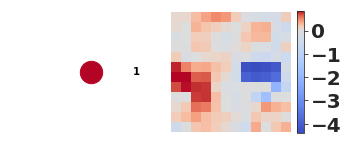

In [75]:
Image('./sde_plots/spatial_loading_cell_type_0_1.png', unconfined=True)